# Tampa Real-Estate Recommender
## Feature Engineering
TB Real Estate Corporation is a real estate investment firm in the Tampa Bay, Florida area.  The real estate market in the Tampa Bay area is very active.  Single family homes are selling quickly.  TB Real Estate Corporation needs to be able to assess the value of homes coming onto the market quickly and accurately so that they can beat the competition in making a competitive offer.   They need to be able to evaluate the listing price against the predicted sale price in order to identify properties that may be priced below market value and would make good investments.  
<br>
The objective of the Feature Engineering is to prepare the features and to build training and testing datasets to optimally support the machine learning models in order to predict the sales price for residential properties.

# 1 Imports and File Locations<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
ext_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'
report_figures = '../reports/figures/'

# 2 Read Sales data into dataframe<a id='2'></a>

In [3]:
df = pd.read_csv(interim_data + 'sales_df_EDA.csv', dtype={'FOLIO': object, 'DOR_CODE': object, 'NBHC': object, 'SECTION_CD': object, 'TOWNSHIP_CD': object, 'RANGE_CD': object}, parse_dates=['S_DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   FOLIO            9974 non-null   object        
 1   S_DATE           9974 non-null   datetime64[ns]
 2   S_AMT            9974 non-null   float64       
 3   SITE_ADDR        9972 non-null   object        
 4   SITE_CITY        9973 non-null   object        
 5   SITE_ZIP         9974 non-null   object        
 6   tBEDS            9974 non-null   float64       
 7   tBATHS           9974 non-null   float64       
 8   JUST             9974 non-null   float64       
 9   LAND             9974 non-null   float64       
 10  BLDG             9974 non-null   float64       
 11  EXF              9974 non-null   float64       
 12  HEAT_AR          9974 non-null   float64       
 13  SD1              9974 non-null   object        
 14  SD2              9974 non-null   object 

# 4 Feature Engineering<a id='4'></a>

In [4]:
# Replace S_DATE with integer sales date epoch
df['sales_date_epoch'] = (df['S_DATE'] - dt.datetime(1970,1,1)).dt.days

In [5]:
county_map = {1: 'South_Tampa',
              2: 'South_Tampa',
              3: 'South_Tampa',
              4: 'Tampa',
              5: 'Tampa',
              6: 'Tampa',
              7: 'Tampa',
              8: 'Tampa',
              9: 'Northwest',
              10: 'Northwest',
              11: 'Northwest',
              12: 'Northern',
              13: 'Northern',
              14: 'Northern',
              15: 'Northern',
              16: 'Northern',
              17: 'Northern',
              18: 'Northeast',
              19: 'Northeast',
              20: 'Northeast',
              21: 'Northeast',
              22: 'East_Bay',
              23: 'Eastern',
              24: 'Eastern',
              25: 'Eastern',
              26: 'Eastern',
              27: 'East_Bay',
              28: 'Southern',
              29: 'Southern'
             }

In [6]:
df['COUNTY_SECT'] = df['MARKET_AREA_CD'].map(county_map)

In [ ]:
# df = df[df.MARKET_AREA_CD >= 26]

In [7]:
df['NBHC'] = pd.to_numeric(df['NBHC'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FOLIO             9974 non-null   object        
 1   S_DATE            9974 non-null   datetime64[ns]
 2   S_AMT             9974 non-null   float64       
 3   SITE_ADDR         9972 non-null   object        
 4   SITE_CITY         9973 non-null   object        
 5   SITE_ZIP          9974 non-null   object        
 6   tBEDS             9974 non-null   float64       
 7   tBATHS            9974 non-null   float64       
 8   JUST              9974 non-null   float64       
 9   LAND              9974 non-null   float64       
 10  BLDG              9974 non-null   float64       
 11  EXF               9974 non-null   float64       
 12  HEAT_AR           9974 non-null   float64       
 13  SD1               9974 non-null   object        
 14  SD2               9974 n

In [8]:
total_land_tax_value = df.LAND.sum()
df['tax_pct_land'] = df.LAND / total_land_tax_value

In [9]:
total_bldg_tax_value = df.BLDG.sum()
df['tax_pct_bldg'] = df.BLDG / total_bldg_tax_value

In [10]:
df['tax_pct_extra_features'] = df.EXF / df.JUST

In [12]:
# Extract independent feature variables to X
# features = ['FOLIO', 'S_DATE', 'sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'COUNTY_SECT', 'JUST', 'HEAT_AR', 'ACREAGE', 'MARKET_AREA_CD']
# features = ['FOLIO', 'S_DATE', 'sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'JUST', 'HEAT_AR', 'ACREAGE', 'MARKET_AREA_CD', 'NBHC']
# features = ['FOLIO', 'S_DATE', 'sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'JUST', 'HEAT_AR', 'ACREAGE', 'NBHC']
# features = ['FOLIO', 'S_DATE', 'sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'HEAT_AR', 'ACREAGE', 'NBHC']
features = ['FOLIO', 'S_DATE', 'sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'HEAT_AR', 'ACREAGE', 'NBHC', 
            'tax_pct_land', 'tax_pct_bldg', 'tax_pct_extra_features']
X = df[features] 

In [13]:
# One-hot encode the County Section
# X = pd.get_dummies(X, columns=['COUNTY_SECT'], prefix=['LOC'])

In [14]:
# One-hot encode the Market Area
# X = pd.get_dummies(X, columns=['MARKET_AREA_CD'], prefix=['MA'])

In [15]:
# One-hot encode the Neighborhood Code
# X = pd.get_dummies(X, columns=['NBHC'], prefix=['NBHC'])

In [16]:
# Extract target dependent variable to y
y = df.S_AMT

In [17]:
# Call train_test_split on X, y. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7979, 12) (7979,)
(1995, 12) (1995,)


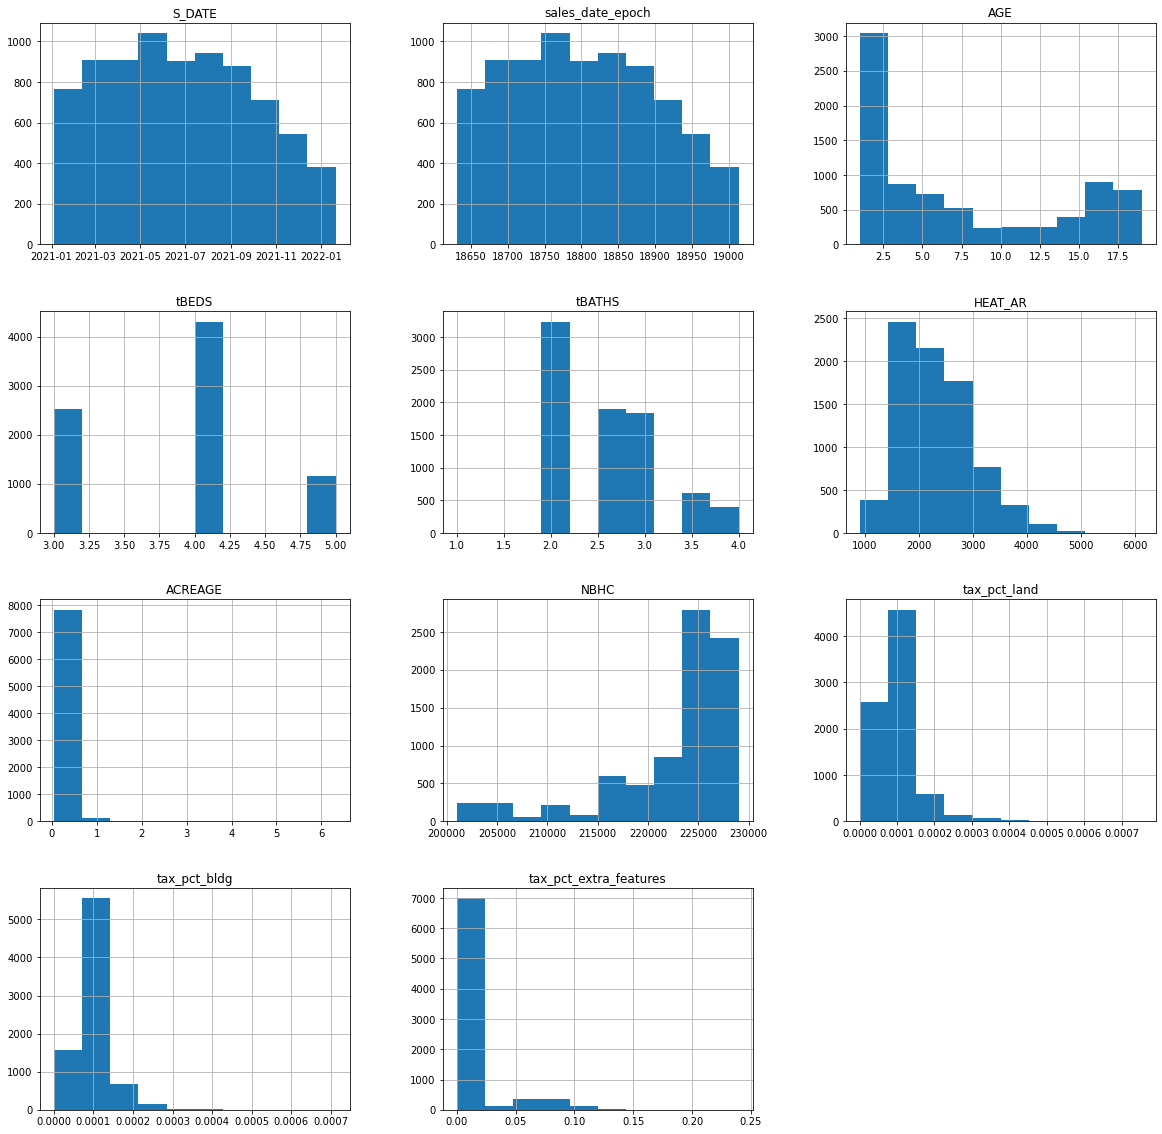

In [18]:
X_train.hist(figsize=(20, 20))
plt.show()

In [19]:
# Save unscaleddata to interim data folder as csv files
X_train.to_csv(interim_data + 'X_train.csv', index=False)
X_test.to_csv(interim_data + 'X_test.csv', index=False)
y_train.to_csv(interim_data + 'y_train.csv', index=False)
y_test.to_csv(interim_data + 'y_test.csv', index=False)

# 5 Scale Features<a id='5'></a>

In [20]:
num_cols = X_train.select_dtypes(include=np.number).columns
num_cols

Index(['sales_date_epoch', 'AGE', 'tBEDS', 'tBATHS', 'HEAT_AR', 'ACREAGE',
       'NBHC', 'tax_pct_land', 'tax_pct_bldg', 'tax_pct_extra_features'],
      dtype='object')

In [21]:
# Apply a standard scaler to the training data
X_train_scaled = X_train
SS_scaler = StandardScaler()
X_train_scaled[num_cols] = SS_scaler.fit_transform(X_train_scaled[num_cols])

In [22]:
X_test_scaled = X_test
X_test_scaled[num_cols] = SS_scaler.transform(X_test_scaled[num_cols])

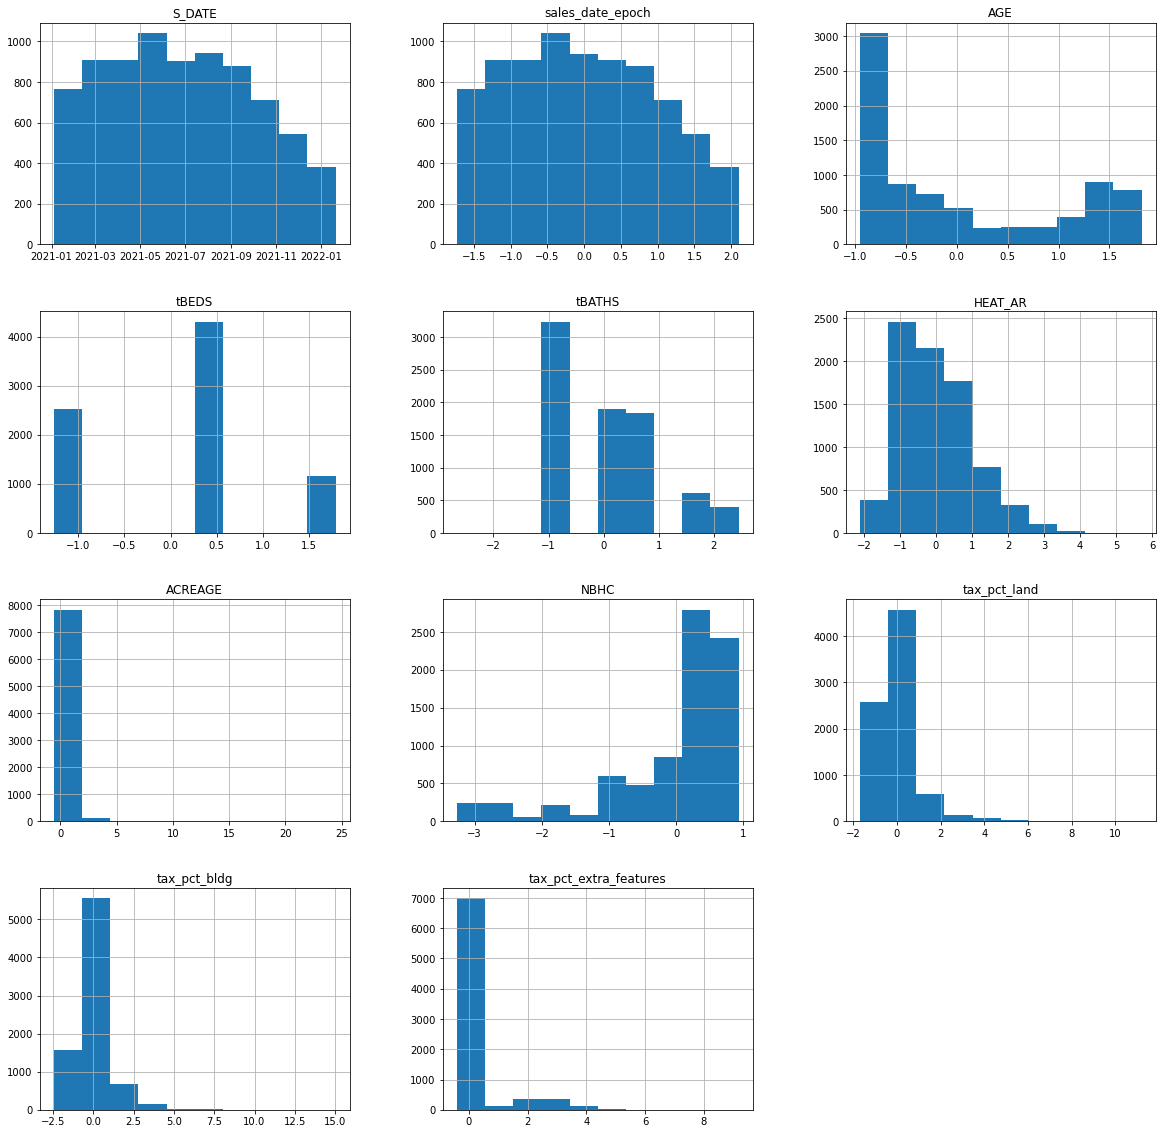

In [23]:
X_train_scaled.hist(figsize=(20, 20))
plt.show()

In [24]:
# Save unscaled data to interim data folder as csv files
X_train_scaled.to_csv(interim_data + 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(interim_data + 'X_test_scaled.csv', index=False)